# Demographics of Data Science Professionals <br> & Factors Affecting Data Scientist Pay
### Kim Dao

## Introduction
Over the past decade, the data science industry has grown tremendously. Numerous polls and rankings have consistently named data scientist and equivalent roles among the most well-paying and in-demand jobs. Are these claims true? Do they hold universally— or do they vary with age, gender, educational attainment, geographic location, and other factors? This project hopes to shed light on the matter of who are having access to opportunities in the data science field.

## Outline
The project will follow this structure:
1. Data
2. Visualization of Factors and their Correlations to Pay
    - Age
    - Gender
    - Race
    - Educational Attainment
    - Geographic Location 
    - Years of Experience
3. Prediction of Pay

## Data

The raw datasets used for this analysis are [Stack Overflow Annual Developer Surveys](https://insights.stackoverflow.com/survey). Stack Overflow is the most popular question and answer forum for professional and enthusiast developers. Its surveys contains a lot of demographic information on developers and their pays from 2011 to 2021. 

In this analysis, I will only focus on some factors, namely: age group, gender, ethnicity, educational attainment, geographic location, years of experience, and their correlations to the pay of data professionals. Because data scientists and analysts compose only a subset of the survey audience, I will filter the datasets to retain only records pertaining to data scientists and analysts.

Below are the data cleaning steps. The final dataset is shown at the end of this section.

In [495]:
import folium
import geopandas as gpd
import json
import matplotlib.ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [353]:
new_base_year = 2017
new_surveys = ['2017_survey_results.csv',
               '2018_survey_results.csv',
               '2019_survey_results.csv',
               '2020_survey_results.csv',
               '2021_survey_results.csv']
old_surveys = ['2016_survey_results.csv',
               '2015_survey_results.csv',
               '2014_survey_results.csv',
               '2013_survey_results.csv',
               '2012_survey_results.csv',
               '2011_survey_results.csv']

raw_dfs = []
for s in new_surveys:
    raw_df = pd.read_csv(s, encoding = 'ISO-8859-1', low_memory=False)
    raw_dfs.append(raw_df)

In [407]:
dfs = []
for df in raw_dfs:
    dfs.append(df.copy())

In [408]:
# constants
AGE = 'Age'
AGE_GROUP = 'AgeGroup'
GENDER = 'Gender'
RACE = 'Race'
EDUCATION = 'EdLevel'
YOE = 'YoE'
YEARS_CODE = 'YearsCodePro'
LOCATION = 'Country'
DEV_TYPE = 'DevType'
PAY = 'ConvertedComp'

# 4 groups of cols: 
#    1- demographics (age, gender, ethnicity)
#    2- education + year of experience
#    3- geo location
#    4- work + pay
cols = [AGE_GROUP, GENDER, RACE,  
        EDUCATION, YEARS_CODE,
        LOCATION,
        DEV_TYPE, PAY]

In [409]:
# rename cols for consistency

# 2017
# - NO Age
# - DeveloperType -> DevType
# - YearsCodedJob -> YearsCodePro
# - FormalEducation -> EdLevel
# - Race -> Ethnicity
# - Salary -> ConvertedComp, e notation reformat
dfs[2017 - new_base_year][AGE] = np.nan
dfs[2017 - new_base_year].rename(columns={'DeveloperType': DEV_TYPE,
                                          'YearsCodedJob': YEARS_CODE,
                                          'FormalEducation': EDUCATION,
                                          'Race': 'Ethnicity',
                                          'Salary': PAY},
                                inplace=True)

# 2018
# - YearsCodingProf -> YearsCodePro
# - ConvertedSalary -> ConvertedComp
# - RaceEthnicity -> Ethnicity
# - FormalEducation -> EdLevel
dfs[2018 - new_base_year].rename(columns={'YearsCodingProf': YEARS_CODE,
                                          'FormalEducation': EDUCATION,
                                          'RaceEthnicity': 'Ethnicity',
                                          'ConvertedSalary': PAY},
                                inplace=True)

# 2021
# - ConvertedCompYearly -> ConvertedComp
dfs[2021 - new_base_year].rename(columns={'ConvertedCompYearly': PAY},
                                inplace=True)

# all
# - Age -> AgeGroup (only some years have raw ages, instead of age groups)
# - Ethnicity -> Race
for i in range (len(dfs)):
    dfs[i].rename(columns={AGE: AGE_GROUP}, inplace=True)
    dfs[i].rename(columns={'Ethnicity': RACE}, inplace=True)

In [410]:
# drop unneccessary rows
for i in range(len(dfs)):
    dfs[i] = dfs[i][cols]

In [411]:
# filter for rows related to data science / analytics
# DevType = Data or business analyst | Data scientist or machine learning specialist | Engineer, data
for i, df in enumerate(dfs):
    df = df.dropna(subset=[DEV_TYPE])
    df = df[df[DEV_TYPE].str.contains('data|analyst', case=False, na=False, regex=True)]
    dfs[i] = df

In [412]:
# 2019 & 2020 have raw ages, group them
def group_age(a):
    if a < 18:
        return 'Under 18'
    elif a >= 18 and a <= 24:
        return '18-24'
    elif a >= 25 and a <= 34:
        return '25-34'
    elif a >= 35 and a <= 44:
        return '35-44'
    elif a >= 45 and a <= 54:
        return '45-54'
    elif a >= 55 and a <= 64:
        return '55-64'
    elif a > 64:
        return 'Over 64'
    else:
        return np.nan

# Inconsistent group name formatting in other years, unify them
def get_age_group(a):
    if '18' in a:
        return 'Under 18'
    elif '18' in a or '24' in a:
        return '18-24'
    elif '25' in a or '34' in a:
        return '25-34'
    elif '35' in a or '44' in a:
        return '35-44'
    elif '45' in a or '54' in a:
        return '45-54'
    elif '55' in a or '64' in a:
        return '55-64'
    elif '65' in a:
        return 'Over 64'
    else:
        return np.nan

dfs[2018 - new_base_year][AGE_GROUP] = dfs[2018 - new_base_year][AGE_GROUP].astype(str).apply(get_age_group)
dfs[2021 - new_base_year][AGE_GROUP] = dfs[2021 - new_base_year][AGE_GROUP].astype(str).apply(get_age_group)

dfs[2019 - new_base_year][AGE_GROUP] = pd.to_numeric(dfs[2019 - new_base_year][AGE_GROUP]).apply(group_age)
dfs[2020 - new_base_year][AGE_GROUP] = pd.to_numeric(dfs[2020 - new_base_year][AGE_GROUP]).apply(group_age)

In [413]:
def get_gender(g):
    if 'Non-binary' in g or 'Gender non-conforming' in g:
        return 'Non-binary'
    elif 'Man' in g or 'Male' in g:
        return 'Man'
    elif 'Woman' in g or 'Female' in g:
        return 'Woman'
    else:
        return np.nan

for i in range(len(dfs)):
    dfs[i][GENDER] = dfs[i][GENDER].astype(str).apply(get_gender)

In [414]:
def get_race(r):
    if r == 'Hispanic or Latino/Latina':
        return 'Hispanic or Latino/a/x'
    elif r == 'Hispanic or Latino/Latina;White or of European descent' or r == 'White or of European descent;Hispanic or Latino/a/x':
        return 'Hispanic or Latino/a/x;White or of European descent'
    elif r == 'Middle Eastern;White or of European descent' or r == 'White or of European descent;Middle Eastern':
        return 'Middle Eastern;White or of European descent'
    elif 'multiracial' in r.lower() or 'biracial' in r.lower():
        return 'Multiracial'
    elif r == 'nan':
        return np.nan
    else:
        return r

for i in range(len(dfs)):
    dfs[i][RACE] = dfs[i][RACE].astype(str).apply(get_race)

In [415]:
def get_education(e):
    if 'Primary' in e.lower() or 'elementary' in e.lower():
        return 'Primary school'
    if 'secondary' in e.lower():
        return 'Secondary school'
    elif 'associate' in e.lower():
        return 'Associate degree'
    elif 'bachelor' in e.lower():
        return 'Bachelor degree'
    elif 'master' in e.lower():
        return 'Master degree'
    elif 'doctoral' in e.lower():
        return 'Doctoral degree'
    elif 'without earning' in e.lower():
        return 'Some college/university'
    elif 'professional' in e.lower():
        return 'Professional degree'
    else:
        return 'Others'

for i in range(len(dfs)):
    dfs[i][EDUCATION] = dfs[i][EDUCATION].astype(str).apply(get_education)

In [416]:
location_replacements = {
    'United States': 'United States of America',
    'Russian Federation': 'Russia',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Iran, Islamic Republic of...': 'Iran',
    'Congo, Republic of the...': 'Democratic Republic of the Congo',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'Lao People\'s Democratic Republic': 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'CÃ´te d\'Ivoire': 'Ivory Coast',
    'The former Yugoslav Republic of Macedonia': 'North Macedonia',
    'Republic of Korea': 'South Korea',
    'Venezuela, Bolivarian Republic of...': 'Venezuela',
    'Bosnia-Herzegovina':'Bosnia and Herzegovina'
}

for i in range(len(dfs)):
    dfs[i][LOCATION].replace(location_replacements, inplace = True)

In [417]:
replacements = {'Less than a year': 1,
                '1 to 2 years': 2,
                '2 to 3 years': 3,
                '3 to 4 years': 4,
                '4 to 5 years': 5,
                '5 to 6 years': 6,
                '6 to 7 years': 7,
                '7 to 8 years': 8,
                '8 to 9 years': 9,
                '9 to 10 years': 10,
                '10 to 11 years': 11,
                '11 to 12 years': 12,
                '12 to 13 years': 13,
                '13 to 14 years': 14,
                '14 to 15 years': 15,
                '15 to 16 years': 16,
                '16 to 17 years': 17,
                '17 to 18 years': 18,
                '18 to 19 years': 19,
                '19 to 20 years': 20,
                '20 or more years': 21}

# Reformat Year of Experience, rounding up to nearest integer year and 
# Accepting some data loss here because 20 or more years is round to 21 years
for i in range(len(dfs)):
    dfs[i][YOE] = dfs[i][YEARS_CODE].replace(replacements)
    dfs[i][YOE] = pd.to_numeric(dfs[i][YOE], errors='coerce')
#     dfs[i] = dfs[i].drop(columns=[YEARS_CODE])

In [418]:
dfs_copy = [] # for testing, TODO: remove
for df in dfs:
    dfs_copy.append(df.copy())

dfs_copy[0].head()

,AgeGroup,Gender,Race,EdLevel,YearsCodePro,Country,DevType,ConvertedComp,YoE
19,NaN,Man,I prefer not to say,Doctoral degree,12 to 13 years,Greece,Data scientist; Other,NaN,13.0
38,NaN,Man,White or of European descent,Bachelor degree,20 or more years,Netherlands,Web developer; Database administrator,NaN,21.0
41,NaN,NaN,NaN,Master degree,17 to 18 years,Denmark,Web developer; Database administrator; DevOps ...,NaN,18.0
63,NaN,NaN,NaN,Master degree,2 to 3 years,United Kingdom,Web developer; Mobile developer; Data scientis...,NaN,3.0
71,NaN,Man,White or of European descent,Bachelor degree,5 to 6 years,Finland,Web developer; Database administrator; Systems...,NaN,6.0


Here is the fully cleaned data frame:

In [420]:
data = pd.concat(dfs)
data.columns

Index(['AgeGroup', 'Gender', 'Race', 'EdLevel', 'YearsCodePro', 'Country',
       'DevType', 'ConvertedComp', 'YoE'],
      dtype='object')

In [421]:
data.head(10)

,AgeGroup,Gender,Race,EdLevel,YearsCodePro,Country,DevType,ConvertedComp,YoE
19,NaN,Man,I prefer not to say,Doctoral degree,12 to 13 years,Greece,Data scientist; Other,NaN,13.0
38,NaN,Man,White or of European descent,Bachelor degree,20 or more years,Netherlands,Web developer; Database administrator,NaN,21.0
41,NaN,NaN,NaN,Master degree,17 to 18 years,Denmark,Web developer; Database administrator; DevOps ...,NaN,18.0
63,NaN,NaN,NaN,Master degree,2 to 3 years,United Kingdom,Web developer; Mobile developer; Data scientis...,NaN,3.0
71,NaN,Man,White or of European descent,Bachelor degree,5 to 6 years,Finland,Web developer; Database administrator; Systems...,NaN,6.0
82,NaN,Man,White or of European descent,Bachelor degree,18 to 19 years,United States of America,Web developer; Mobile developer; Data scientis...,NaN,19.0
84,NaN,Man,"Hispanic or Latino/Latina; Native American, Pa...",Bachelor degree,NaN,Mexico,Web developer; Mobile developer; Database admi...,NaN,NaN
91,NaN,Man,White or of European descent,Master degree,10 to 11 years,Germany,Machine learning specialist; Developer with a ...,NaN,11.0
94,NaN,Man,I donât know,Secondary school,1 to 2 years,India,Web developer; Desktop applications developer;...,NaN,2.0
96,NaN,Man,White or of European descent,Bachelor degree,1 to 2 years,United States of America,Web developer; Desktop applications developer;...,NaN,2.0


## Visualization

Visualising the composition of data professionals with regards to various factors, and how those factors correlate with annual pay:
- age
- gender
- race
- educational attainment
- geographic location
- year of experience

In [715]:
# Constants
PAIR_FIG_SIZE = (15, 6)
PCT_LABEL = 'Percentage'
PAY_LABEL = 'Annual Pay'

# Common helpers
def format_pay_axis(ax, isX):
    if isX:
        axis = ax.get_xaxis()
    else: 
        axis = ax.get_yaxis()
    axis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.set_style('whitegrid')

### Age
Figure 1.1 shows that young people make up a large percentage of data scientists. Figure 1.2 indicates that there is a very weak correlation between age and pay. Even the youngest data scientists could earn the top pay brackets.

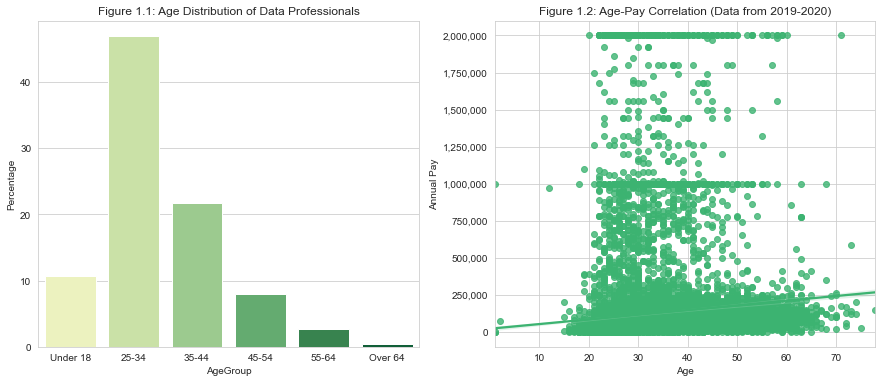

In [716]:
# Age
age_fig, age_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

# Plot age distribution
age_dist = data[AGE_GROUP].value_counts(dropna=True)
total_count = age_dist.sum()
age_dist = (age_dist / total_count * 100).rename('Percentage').reset_index()

age_plot = sns.barplot(ax=age_axes[0],
                       x='index', 
                       y='Percentage', 
                       data=age_dist, 
                       palette='YlGn', # YlGnBu Greens_d mako YlGn summer_r
                       order=['Under 18', '25-34', '35-44', '45-54', '55-64', 'Over 64'])
age_plot.set(xlabel=AGE_GROUP, title='Figure 1.1: Age Distribution of Data Professionals')


# Plot age-pay linear regression 
age_pay_data = pd.concat([raw_dfs[2019 - new_base_year], raw_dfs[2020 - new_base_year]]).loc[:, [AGE, PAY, DEV_TYPE]].dropna()
age_pay_data.rename(columns={PAY: PAY_LABEL}, inplace=True)
age_pay_data = age_pay_data[age_pay_data[DEV_TYPE].str.contains('data|analyst', case=False, na=False, regex=True)]

# There are a lot of data points claiming to be 99 year-old people...
age_pay_data = age_pay_data[age_pay_data[AGE] < 80] 

age_pay_plot = sns.regplot(ax=age_axes[1], x=AGE, y=PAY_LABEL, data=age_pay_data, color='mediumseagreen')
age_pay_plot.set(title='Figure 1.2: Age-Pay Correlation (Data from 2019-2020)')
age_axes[1].ticklabel_format(axis='y', style='plain')
format_pay_axis(age_axes[1], False)

### Gender

Figure 2.1 shows that men make up 93.2% the data points, women 5.6%, and non-binary people 1.2%. This suggests that the data science field is dominated by men. However, average pay is relatively equal across all gender groups, as suggested by Figure 2.2. Still, outliers at the higher pays are mostly men.

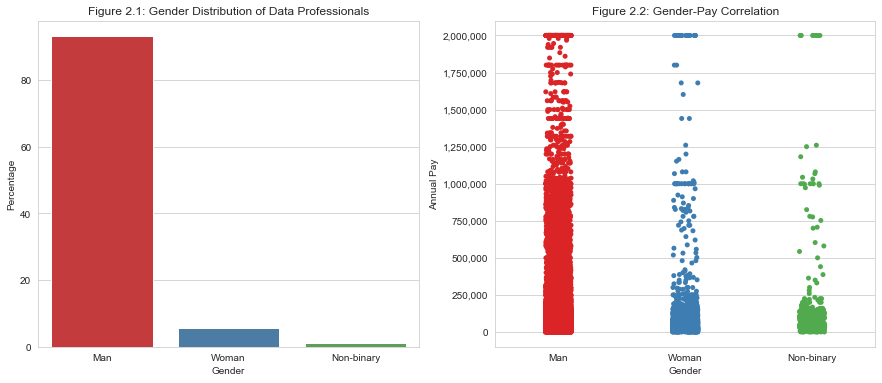

In [723]:
# Gender 
gender_fig, gender_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)
pal = sns.color_palette('Set1', 3, .9)

# Plot gender distribution
gender_dist = data[GENDER].value_counts(dropna=True)
total_count = gender_dist.sum()
gender_dist = (gender_dist / total_count * 100).rename('Percentage').reset_index()

gender_plot = sns.barplot(ax=gender_axes[0],
                          x='index', 
                          y='Percentage', 
                          data=gender_dist,
                          palette=pal)
gender_plot.set(xlabel=GENDER, title='Figure 2.1: Gender Distribution of Data Professionals')

# Plot correlation
sns.set_palette(pal)
gender_pay_data = data.loc[:, [GENDER, PAY]].dropna()

# Coincidentally, by removing from the dataset people claiming to 80+ years old in the Age section above, 
# we have no one earning 2000000+ left. Uncomment the line below if you want to see the full data
gender_pay_data = gender_pay_data[gender_pay_data[PAY] < 2001000]

gender_pay_data.rename(columns={PAY: PAY_LABEL}, inplace=True)

gender_pay_plot = sns.stripplot(ax=gender_axes[1], 
                                x=GENDER, 
                                y=PAY_LABEL, 
                                data=gender_pay_data, 
                                palette=pal)
gender_pay_plot.set(xlabel=GENDER, title='Figure 2.2: Gender-Pay Correlation')
format_pay_axis(gender_axes[1], False)

In [531]:
gender_dist

,index,Percentage
0,Man,93.183440
1,Woman,5.638448
2,Non-binary,1.178112


### Race

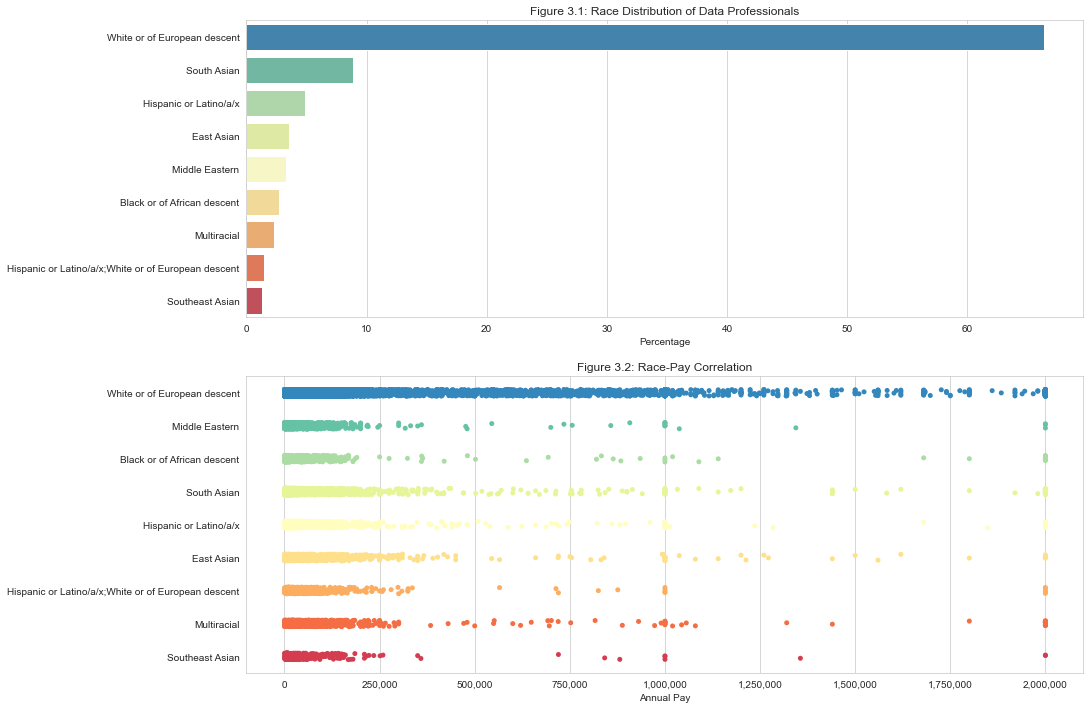

In [724]:
# Race 
race_fig, race_axes = plt.subplots(2, 1, figsize=(PAIR_FIG_SIZE[0], 2*PAIR_FIG_SIZE[1]))

# Plot race distribution
race_pct_threshold = 1
race_dist = data[RACE].value_counts(dropna=True)
race_total_count = race_dist.sum()
race_dist = (race_dist / race_total_count * 100).rename('Percentage').reset_index()
dominant_race_dist = race_dist[race_dist['Percentage'] > race_pct_threshold]

race_plot = sns.barplot(
    ax=race_axes[0],
    y='index', 
    x='Percentage', 
    data=dominant_race_dist,
    palette='Spectral_r'
) # Set3 Spectral

race_plot.set(xlabel='Percentage', ylabel='', title='Figure 3.1: Race Distribution of Data Professionals')

# Plot correlation
race_pay_data = data.loc[:, [RACE, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

# Coincidentally, by removing from the dataset people claiming to 80+ years old in the Age section above, 
# we have no one earning 2000000+ left. Uncomment the line below if you want to see the full data
race_pay_data = race_pay_data[race_pay_data[PAY_LABEL] < 2001000]

dominant_race_pay_data = race_pay_data.loc[race_pay_data[RACE].isin(list(dominant_race_dist['index']))]
race_pay_plot = sns.stripplot(
    ax=race_axes[1], 
    y=RACE, 
    x=PAY_LABEL, 
    data=dominant_race_pay_data, 
    palette='Spectral_r'
)
race_pay_plot.set(xlabel=PAY_LABEL, ylabel='', title='Figure 3.2: Race-Pay Correlation')
format_pay_axis(race_axes[1], True)

### Educational Attainment 

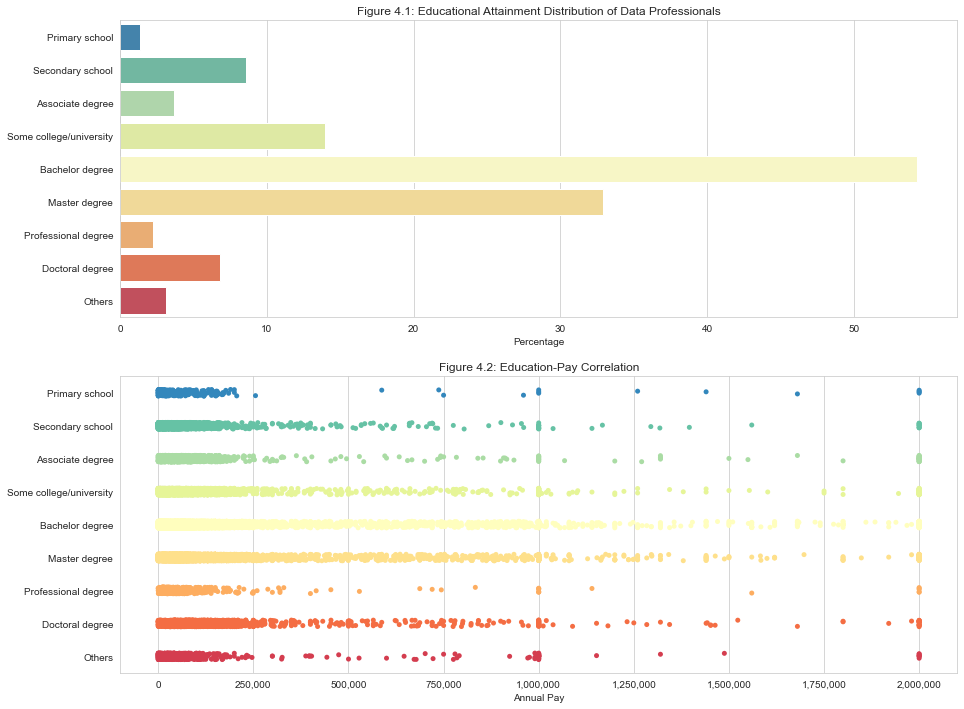

In [725]:
# Educational Attainment  
edu_fig, edu_axes = plt.subplots(2, 1, figsize=(PAIR_FIG_SIZE[0], 2*PAIR_FIG_SIZE[1]))

# Plot education distribution
order = [
    'Primary school',
    'Secondary school',
    'Associate degree',
    'Some college/university',
    'Bachelor degree', 
    'Master degree',
    'Professional degree',
    'Doctoral degree',
    'Others'
]

edu_dist = data[EDUCATION].value_counts(dropna=True)
edu_total_count = edu_dist.sum()
edu_dist = (edu_dist / race_total_count * 100).rename('Percentage').reset_index()

edu_plot = sns.barplot(
    ax=edu_axes[0],
    y='index', 
    x=PCT_LABEL, 
    data=edu_dist,
    palette='Spectral_r',
    order=order
)

edu_plot.set(xlabel=PCT_LABEL, ylabel='', title='Figure 4.1: Educational Attainment Distribution of Data Professionals')

# Plot correlation
edu_pay_data = data.loc[:, [EDUCATION, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

# Coincidentally, by removing from the dataset people claiming to 80+ years old in the Age section above, 
# we have no one earning 2000000+ left. Uncomment the line below if you want to see the full data
edu_pay_data = edu_pay_data[edu_pay_data[PAY_LABEL] < 2001000]

edu_pay_plot = sns.stripplot(
    ax=edu_axes[1], 
    y=EDUCATION, 
    x=PAY_LABEL, 
    data=edu_pay_data, 
    palette='Spectral_r',
    order=order
)
edu_pay_plot.set(xlabel=PAY_LABEL, ylabel='', title='Figure 4.2: Education-Pay Correlation')
format_pay_axis(edu_axes[1], True)

### Years of Experience 

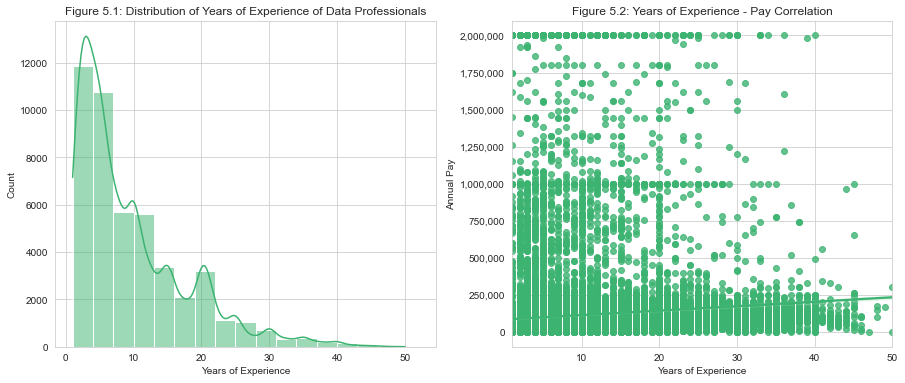

In [726]:
# Years of Experience 
yoe_fig, yoe_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

# Plot age distribution
yoe_dist = data.dropna(subset=[YOE])

yoe_plot = sns.histplot(
    ax=yoe_axes[0],
    x=YOE, 
    data=yoe_dist, 
    color='mediumseagreen',
    binwidth=3,
    kde=True
)
yoe_plot.set(xlabel='Years of Experience', title='Figure 5.1: Distribution of Years of Experience of Data Professionals')

# Plot yoe-pay linear regression 
yoe_pay_data = data.loc[:, [YOE, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

# Coincidentally, by removing from the dataset people claiming to 80+ years old in the Age section above, 
# we have no one earning 2000000+ left. Uncomment the line below if you want to see the full data
yoe_pay_data = yoe_pay_data[yoe_pay_data[PAY_LABEL] < 2001000]

yoe_pay_plot = sns.regplot(
    ax=yoe_axes[1], 
    x=YOE, 
    y=PAY_LABEL, 
    data=yoe_pay_data, 
    color='mediumseagreen'
)
yoe_pay_plot.set(xlabel='Years of Experience', title='Figure 5.2: Years of Experience - Pay Correlation')
format_pay_axis(yoe_axes[1], False)

### Geographic Location 

In [727]:
# Geographic Location 

# Add basic map
base_world_geo_data_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo_data = f'{base_geo_data_url}/world-countries.json'
counts = pd.DataFrame(data={'Counts': data[LOCATION].value_counts(dropna=True)})
counts = counts.reset_index()
counts = counts.rename(columns={'index': 'Country'})
count_bins = [0, 1000, 5000, 10000, 15000, 20000]

count_map = folium.Map()
folium.Choropleth(
    geo_data=world_geo_data,
    data=counts,
    columns=['Country', 'Counts'],
    bins=count_bins,
    key_on='feature.properties.name',
    fill_color ='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Number of Data Professionals',
    nan_fill_color='white'
).add_to(count_map)

# Add markers for interesting (Top 10) data points
LAT = 'latitude'
LONG = 'longitude'
nlargest = 10

high_counts = counts.nlargest(nlargest, 'Counts').set_index('Country')

raw_json = json.loads(open('country-lat-long.json').read())['ref_country_codes']
world_coords = {}
for c in raw_json:
    world_coords[c['country']] = { LAT: c[LAT], LONG: c[LONG] }

world_coords['United States of America'] = world_coords['United States']
world_coords['Russia'] = world_coords['Russian Federation']
del world_coords['United States']
del world_coords['Russian Federation']

for i, c in enumerate(list(high_counts.index)):
    annotation = f"#{i+1}, {c}: {high_counts.loc[c]['Counts']}"
    folium.Circle(
        location=[world_coords[c][LAT], world_coords[c][LONG]],
        tooltip=annotation,
        color='red',
        radius=100 * int(high_counts.loc[c]['Counts']),
        weight=1,
        fill=True,
        fill_opacity=0.3,
    ).add_to(count_map)

count_map

### Pay

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, 'Annual Pay'),
 Text(0.5, 1.0, 'Figure 6.2: Pay Distribution in the Interquatile Range')]

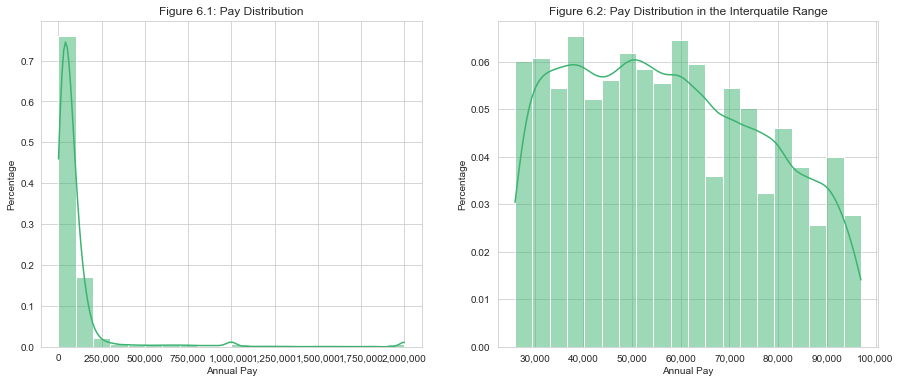

In [747]:
# Pay
pay_fig, pay_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

pay_threshold = 2001000
pay_data = data[data[PAY] < pay_threshold]

pay_plot = sns.histplot(
    ax=pay_axes[0],
    x=PAY, 
    data=pay_data, 
    color='mediumseagreen',
    bins=20,
    kde=True,
    stat='probability'
)

format_pay_axis(pay_axes[0], True)
pay_plot.set(ylabel=PCT_LABEL, xlabel=PAY_LABEL, title='Figure 6.1: Pay Distribution')

quantiles = data[PAY].quantile([0.25, 0.75])
mid_pay_data = data.loc[(data[PAY] >= quantiles[0.25]) & (data[PAY] <= quantiles[0.75])]

mid_pay_plot = sns.histplot(
    ax=pay_axes[1],
    x=PAY, 
    data=mid_pay_data, 
    color='mediumseagreen',
    bins=20,
    kde=True,
    stat='probability'
)

format_pay_axis(pay_axes[1], True)
mid_pay_plot.set(ylabel=PCT_LABEL, xlabel=PAY_LABEL, title='Figure 6.2: Pay Distribution in the Interquatile Range')

## Citations
https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
https://python-visualization.github.io/folium/quickstart.html